<a href="https://colab.research.google.com/github/WHYS-TEAM/Coding_study/blob/main/Adversarial_Collaborative_Filtering_for_Free_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Adversarial Collaborative Filtering for Free

In [ ]:
#-*- coding:utf-8 -*-
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import random_split
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_data = '/content/drive/My Drive/Colab Notebooks/Naver_webtoon/'

'Adversarial Collaborative Filtering for Free.ipynb'
'Adversarial Collaborative Filtering for Free.pdf'
'Adversarial Collaborative Filtering for Free_v2.ipynb'
'A Lightweight Method for Modeling Confidence in Recommendations with Learned Beta Distributions.ipynb'
'A Lightweight Method for Modeling Confidence in Recommendations with Learned Beta Distributions.pdf'
 BPR.ipynb
 _lbd_model.pth
 model.pth
 movies.dat
 ratings.dat
 README
 users.dat
'과제 문제.docx'


In [ ]:
# 파일 경로
ratings_file_path = path_data + 'ratings.dat'
users_file_path = path_data + 'users.dat'
movies_file_path = path_data + 'movies.dat'

In [ ]:
movies_file_path

'/content/drive/My Drive/Colab Notebooks/Naver_webtoon/movies.dat'

In [ ]:
movies = pd.read_csv(movies_file_path, sep='::', engine='python', names=['MovieID', 'Title', 'Genres'], encoding='ISO-8859-1')
ratings = pd.read_csv(ratings_file_path, sep='::', engine='python', names=['UserID', 'MovieID', 'Rating', 'Timestamp'], encoding='ISO-8859-1')
users = pd.read_csv(users_file_path, sep='::', engine='python', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], encoding='ISO-8859-1')

Epoch 1, Train Loss: 123.2372118461155, Test Loss: 105.32576848295949
Epoch 2, Train Loss: 80.096711961108, Test Loss: 80.25190009973238
Epoch 3, Train Loss: 52.86396928056264, Test Loss: 62.4253592869205
Epoch 4, Train Loss: 34.86771507958762, Test Loss: 48.563190699233424
Epoch 5, Train Loss: 21.82631990990422, Test Loss: 36.1568118361256
Epoch 6, Train Loss: 12.439343056767244, Test Loss: 26.493490002039447
Epoch 7, Train Loss: 7.0906412241478725, Test Loss: 20.34621452736428
Epoch 8, Train Loss: 4.271631042162578, Test Loss: 16.37514362066908
Epoch 9, Train Loss: 2.7212571261864174, Test Loss: 13.713083313554144
Epoch 10, Train Loss: 1.8454383918282624, Test Loss: 11.87382218295046
Epoch 11, Train Loss: 1.3427839041785865, Test Loss: 10.58049426176359
Epoch 12, Train Loss: 1.0481416680495554, Test Loss: 9.66422707284503
Epoch 13, Train Loss: 0.8709201274662542, Test Loss: 8.9917781566415
Epoch 14, Train Loss: 0.7588157893962305, Test Loss: 8.499027946111186
Epoch 15, Train Loss: 0.

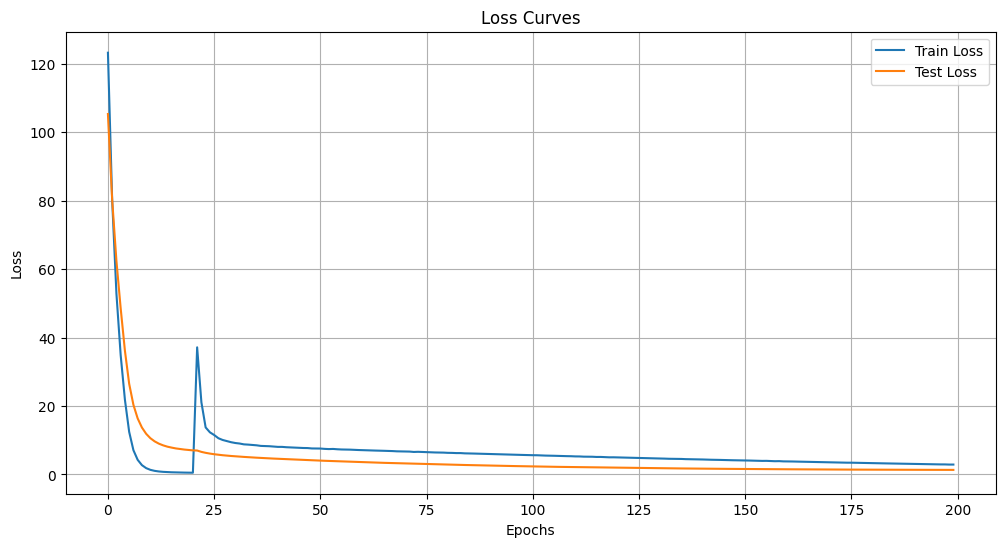

In [ ]:
# 데이터 전처리
ratings = ratings[['UserID', 'MovieID', 'Rating']]

# User와 Movie의 고유 ID 생성
user_ids = ratings['UserID'].unique()
movie_ids = ratings['MovieID'].unique()
user_id_map = {id: idx for idx, id in enumerate(user_ids)}
movie_id_map = {id: idx for idx, id in enumerate(movie_ids)}

ratings['UserID'] = ratings['UserID'].map(user_id_map)
ratings['MovieID'] = ratings['MovieID'].map(movie_id_map)

# 데이터셋 클래스 정의
class MovielensDataset(Dataset):
    def __init__(self, ratings):
        self.users = torch.tensor(ratings['UserID'].values, dtype=torch.long)
        self.movies = torch.tensor(ratings['MovieID'].values, dtype=torch.long)
        self.ratings = torch.tensor(ratings['Rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]

dataset = MovielensDataset(ratings)

# 시드 고정
seed = 777
torch.manual_seed(seed)


# 데이터셋 분할 (80% train, 20% test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# SharpCF 모델 정의
class SharpCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super(SharpCF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

    def forward(self, user, item):
        user_embedded = self.user_embedding(user)
        item_embedded = self.item_embedding(item)
        return (user_embedded * item_embedded).sum(1)

# 모델 초기화
num_users = len(user_ids)
num_items = len(movie_ids)
embedding_dim = 128
model = SharpCF(num_users, num_items, embedding_dim).cuda()

# 손실 함수 및 최적화기 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Trajectory Loss 계산을 위한 변수
T_start = 20
lambda_trajectory = 0.1
past_weights = None

# 모델 학습 루프
def train(model, train_loader, test_loader, optimizer, criterion, num_epochs=200, save_path='/content/drive/My Drive/path_to_your_model/model.pth'):
    train_losses = []
    test_losses = []
    past_outputs = None
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for users, movies, ratings in train_loader:
            users, movies, ratings = users.cuda(), movies.cuda(), ratings.cuda()

            optimizer.zero_grad()
            outputs = model(users, movies)
            loss = criterion(outputs, ratings)

            if epoch > T_start:
              if past_outputs is None or past_outputs.size() != outputs.size():
                past_outputs = torch.zeros_like(outputs)
              trajectory_loss = lambda_trajectory * ((outputs - past_outputs) ** 2).sum()
              loss += trajectory_loss
              past_outputs = outputs.clone().detach()

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for users, movies, ratings in test_loader:
                users, movies, ratings = users.cuda(), movies.cuda(), ratings.cuda()
                outputs = model(users, movies)
                loss = criterion(outputs, ratings)
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')

    return train_losses, test_losses

# 모델 학습
train_losses, test_losses = train(model, train_loader, test_loader, optimizer, criterion)

# 학습 과정의 손실 함수 변화 시각화
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def save_model(model, save_path=path_data+'model.pth'):
  torch.save(model.state_dict(), save_path)
  print(f'Model saved to {save_path}')
save_model(model)

Model saved to /content/drive/My Drive/Colab Notebooks/Naver_webtoon/model.pth


In [ ]:
# 모델 로드 및 평가
def load_model(model, load_path='/content/drive/My Drive/path_to_your_model/model.pth'):
    model.load_state_dict(torch.load(load_path))
    model.eval()
    print(f'Model loaded from {load_path}')

def evaluate_model(model, test_loader):
    model.eval()
    true_ratings = []
    predicted_ratings = []
    with torch.no_grad():
        for users, movies, ratings in test_loader:
            users, movies, ratings = users.cuda(), movies.cuda(), ratings.cuda()
            outputs = model(users, movies)
            true_ratings.extend(ratings.cpu().numpy())
            predicted_ratings.extend(outputs.cpu().numpy())

    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    mae = mean_absolute_error(true_ratings, predicted_ratings)
    return rmse, mae

# 모델 로드
#load_model(model)

# 테스트 셋 평가
rmse, mae = evaluate_model(model, test_loader)
print(f'RMSE: {rmse}, MAE: {mae}')

# 예시 사용자에 대한 추천 결과 확인
def recommend(model, user_id, top_k=10):
    model.eval()
    user_tensor = torch.tensor([user_id_map[user_id]], dtype=torch.long).cuda()
    item_tensor = torch.arange(num_items, dtype=torch.long).cuda()

    with torch.no_grad():
        scores = model(user_tensor, item_tensor).cpu().numpy()

    top_k_items = np.argsort(scores)[-top_k:][::-1]
    return [list(movie_id_map.keys())[i] for i in top_k_items]

# 예시 사용자에 대한 추천 결과 확인
example_user_id = 1  # User ID 예시
recommended_items = recommend(model, example_user_id, top_k=10)
print(f"Recommended items for user {example_user_id}: {recommended_items}")

RMSE: 1.1531766653060913, MAE: 0.9471275210380554
Recommended items for user 1: [1511, 1857, 3085, 3065, 2342, 887, 526, 2673, 3460, 823]


In [ ]:
# 추론 및 결과 확인
def recommend(model, user_id, top_k=10):
    model.eval()
    user_tensor = torch.tensor([user_id_map[user_id]], dtype=torch.long).cuda()
    item_tensor = torch.arange(num_items, dtype=torch.long).cuda()

    with torch.no_grad():
        scores = model(user_tensor, item_tensor).cpu().numpy()

    top_k_items = np.argsort(scores)[-top_k:][::-1]
    return [list(movie_id_map.keys())[i] for i in top_k_items]

# 예시 사용자에 대한 추천 결과 확인
example_user_id = 1  # User ID 예시
recommended_items = recommend(model, example_user_id, top_k=10)
print(f"Recommended items for user {example_user_id}: {recommended_items}")

Recommended items for user 1: [1511, 1857, 3085, 3065, 2342, 887, 526, 2673, 3460, 823]
